In [196]:
import io
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

class TClass:
    def __init__(self, name, attrs):
        self.name = name
        # сохраняем в классе атрибуты отсортированными
        self.attrs = sorted(attrs)
        self.attrs_num = len(self.attrs)
        self.obj_num = 1
        ##print("Init: " + self.name + " Attrs = " + str(self.attrs))

classes = []
class_num = 0

def add_new_class(attrs):
    global class_num

    class_num += 1
    new_class_name = "Класс " + str(class_num)
    new_class = TClass(new_class_name, attrs)
    classes.append(new_class)

def get_class_by_attrs(attrs):
    class_name = "_NOT_FOUND_"
    # цикл по всем ранее созданным классам
    for cls in classes:
        # грубое сравнение - по числу атрибутов
        if len(cls.attrs) == len(attrs):
            # предполагаем, что нашли подходящий класс
            class_found = True
            # сравнение по атрибутам
            for idx, attr in enumerate(sorted(attrs)):
                #print(str(idx) + " " + attr + " " + cls.attrs[idx])
                if attr != cls.attrs[idx]:
                    #print("Not equal, not this class...")
                    class_found = False

            if class_found:
                cls.obj_num = cls.obj_num + 1
                #print(cls.name + " - obj_num increased up to " + str(cls.obj_num))
                class_name = cls.name
                break

    return class_name

df_objs_attrs = pd.read_csv('/content/All_objs_attrs_test_set.csv', delimiter=';')
df_objs_attrs = df_objs_attrs.reset_index()

# формируем список ID объектов
objs = df_objs_attrs['OBJ_KEY'].unique()

# Словарь: для каждого объекта - список его атрибутов
# для назначения класса каждому объекту после всех операций с классами
# (для простоты реализации, не вводим список объектов для каждого класса на этапе создания классов)
objs_attrs = {}

for obj in objs:
    obj_attrs = df_objs_attrs[df_objs_attrs['OBJ_KEY'].str.fullmatch(obj)] \
     ['TIME_SERIES_KEY'].to_list()
    # добавляем запись в словарь
    objs_attrs[obj] = obj_attrs
    # Если атрибутов (доп. переменных) нет - то класс не присваиваем
    if len(obj_attrs) > 0:
        # Есть ли класс с таким набором атрибутов?
        obj_class_name = get_class_by_attrs(obj_attrs)
        if obj_class_name == "_NOT_FOUND_":
            # Нет - создать новый класс
            obj_class_name = add_new_class(obj_attrs)

    # Отображаем прогресс
    #print(".", end='')

In [197]:
df_cls = pd.DataFrame.from_records(vars(o) for o in classes)

In [198]:
pd.reset_option('display.max_rows', None)
pd.set_option('display.max_rows', 20)
df_cls

,name,attrs,attrs_num,obj_num
0,Класс 1,"[_CORR, _DZ, _MMAN]",3,18
1,Класс 2,[_DZ],1,5
2,Класс 3,"[_CORR, _MMAN]",2,8
3,Класс 4,"[_CORR, _MMAN, _SPL]",3,1
4,Класс 5,"[_CORR, _MMAN, _SFD]",3,1
5,Класс 6,"[_CORR, _MMAN, _UPL]",3,1
6,Класс 7,"[_CORR, _DZ, _MMAN, _PDZ]",4,24
7,Класс 8,"[_CORR, _DZ, _MMAN, _OVR, _OVR2, _PDZ]",6,1
8,Класс 9,"[_CORR, _DZ, _MMAN, _PDZ, _TRF, _TSR, _TTG]",7,1
9,Класс 10,"[_CORR, _DZ, _M, _MMAN, _PDZ]",5,1


In [199]:
# подсчет количества совпадающих атрибутов у двух классов
def get_num_of_matched_attrs(class_num_1, class_num_2):
  return len(set(df_cls['attrs'][class_num_1]) & set(df_cls['attrs'][class_num_2]))

In [200]:
# ВАРИАНТ 1 - степень "похожести" как отношение числа совпадающих атрибутов
#             к максимальному из количества атрибутов у сравниваемых классов
#             (значения в диапазоне от 0 до 1)
# цикл по всем классам - строим "матрицу похожести"
matrix = []
for i, row in df_cls.iterrows():
    mrow = []
    for j in range(0, i):
        mrow.append(float('nan'))
    for j in range(i, len(df_cls.index)):
        attrs_num_1 = df_cls['attrs_num'][i]
        attrs_num_2 = df_cls['attrs_num'][j]
        attrs_num_max = max(attrs_num_1, attrs_num_2)
        ##print(str(attrs_num_1) + " " + str(attrs_num_2) + " " + str(attrs_num_max) \
        ##      + " " + str(get_num_of_matched_attrs(i, j)/attrs_num_max))
        mrow.append(get_num_of_matched_attrs(i, j)/attrs_num_max)

    matrix.append(mrow)
    ##print(".", end='')

df2 = pd.DataFrame(matrix)

# заполняем "нижнюю часть" матрицы
for i, row in df2.iterrows():
  for j in range(0, i):
    df2.iat[i, j] = df2.iat[j, i]

# формируем "матрицу несходства"
df3 = 1 - df2

In [201]:
# ВАРИАНТ 2 - матрица несходства по разности макс. числа атрибутов и
#             числа совпадающих (возможные значения от 1 до макс. числа атрибутов)
# 1 - то есть 1 несовпадающий атрибут, 0 быть не может, т.к. это был бы один и тот же класс
matrix = []
for i, row in df_cls.iterrows():
    mrow = []
    for j in range(0, i):
        mrow.append(float('nan'))
    for j in range(i, len(df_cls.index)):
        attrs_num_1 = df_cls['attrs_num'][i]
        attrs_num_2 = df_cls['attrs_num'][j]
        attrs_num_max = max(attrs_num_1, attrs_num_2)
        mrow.append(attrs_num_max - get_num_of_matched_attrs(i, j))

    matrix.append(mrow)
    ##print(".", end='')

df2 = pd.DataFrame(matrix)

# заполняем "нижнюю часть" матрицы
for i, row in df2.iterrows():
  for j in range(0, i):
    df2.iat[i, j] = df2.iat[j, i]

df3 = df2

In [202]:
pd.set_option('display.float_format', '{:.2f}'.format)
df3

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00,2.00,1.00,1.00,1.00,1.00,1.00,3.00,4.00,2.00,3.00,1.00,4
1,2.00,0.00,2.00,3.00,3.00,3.00,3.00,5.00,6.00,4.00,5.00,3.00,6
2,1.00,2.00,0.00,1.00,1.00,1.00,2.00,4.00,5.00,3.00,4.00,2.00,5
3,1.00,3.00,1.00,0.00,1.00,1.00,2.00,4.00,5.00,3.00,4.00,2.00,5
4,1.00,3.00,1.00,1.00,0.00,1.00,2.00,4.00,5.00,3.00,4.00,2.00,5
5,1.00,3.00,1.00,1.00,1.00,0.00,2.00,4.00,5.00,3.00,4.00,2.00,5
6,1.00,3.00,2.00,2.00,2.00,2.00,0.00,2.00,3.00,1.00,3.00,1.00,3
7,3.00,5.00,4.00,4.00,4.00,4.00,2.00,0.00,3.00,2.00,3.00,3.00,3
8,4.00,6.00,5.00,5.00,5.00,5.00,3.00,3.00,0.00,3.00,4.00,4.00,3
9,2.00,4.00,3.00,3.00,3.00,3.00,1.00,2.00,3.00,0.00,2.00,1.00,2


In [203]:
# Формируем condensed distance matrix
# Если передать исходную df3 в функцию linkage, получим сообщение:
# ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

cond_df3 = squareform(df3)
print(cond_df3.shape)

(78,)


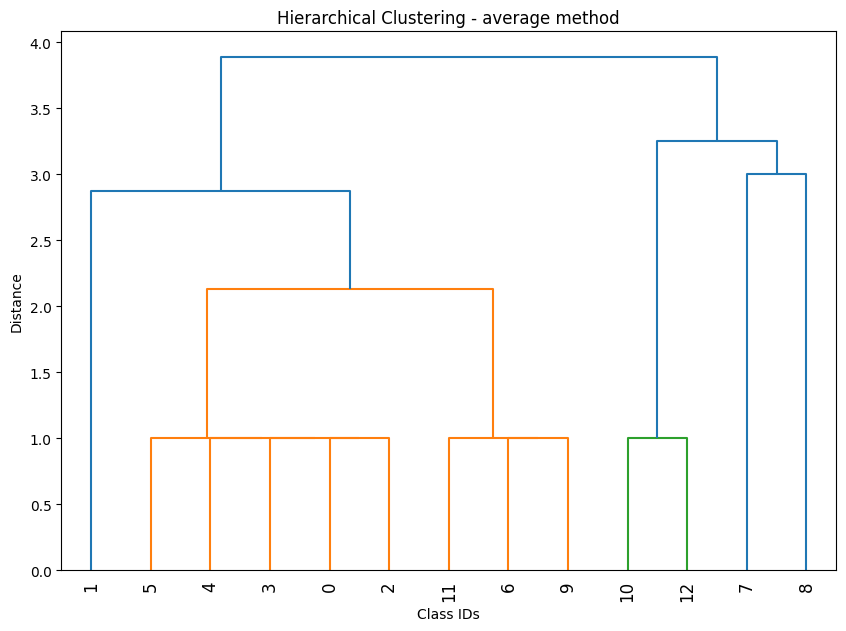

In [204]:
method = 'average'
Z = linkage(cond_df3, method)

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df3.index, leaf_rotation=90)
plt.title('Hierarchical Clustering - ' + method + ' method')
plt.xlabel('Class IDs')
plt.ylabel('Distance')

# Show the figure
plt.show()

In [205]:
print(len(Z))

12


In [206]:
Z
# Здесь мы видим матрицу, каждая строка которой - шаг кластеризации
# т.е. кластеризация выполняется всегда попарно
# (это также можно увидеть, запустив ниже 5. Print merge history in chronological order)

array([[ 0.        ,  2.        ,  1.        ,  2.        ],
       [ 3.        , 13.        ,  1.        ,  3.        ],
       [ 4.        , 14.        ,  1.        ,  4.        ],
       [ 5.        , 15.        ,  1.        ,  5.        ],
       [ 6.        ,  9.        ,  1.        ,  2.        ],
       [11.        , 17.        ,  1.        ,  3.        ],
       [10.        , 12.        ,  1.        ,  2.        ],
       [16.        , 18.        ,  2.13333333,  8.        ],
       [ 1.        , 20.        ,  2.875     ,  9.        ],
       [ 7.        ,  8.        ,  3.        ,  2.        ],
       [19.        , 22.        ,  3.25      ,  4.        ],
       [21.        , 23.        ,  3.88888889, 13.        ]])

In [207]:
# 5. Print merge history in chronological order
print("\nMerge history (from first to last merge):")
for i, (idx1, idx2, dist, size) in enumerate(Z):
    print(f"Step {i+1}: Merged cluster {idx1} and {idx2} (distance={dist:.2f}) forming new cluster {len(Z)+i} with {size} elements")


Merge history (from first to last merge):
Step 1: Merged cluster 0.0 and 2.0 (distance=1.00) forming new cluster 12 with 2.0 elements
Step 2: Merged cluster 3.0 and 13.0 (distance=1.00) forming new cluster 13 with 3.0 elements
Step 3: Merged cluster 4.0 and 14.0 (distance=1.00) forming new cluster 14 with 4.0 elements
Step 4: Merged cluster 5.0 and 15.0 (distance=1.00) forming new cluster 15 with 5.0 elements
Step 5: Merged cluster 6.0 and 9.0 (distance=1.00) forming new cluster 16 with 2.0 elements
Step 6: Merged cluster 11.0 and 17.0 (distance=1.00) forming new cluster 17 with 3.0 elements
Step 7: Merged cluster 10.0 and 12.0 (distance=1.00) forming new cluster 18 with 2.0 elements
Step 8: Merged cluster 16.0 and 18.0 (distance=2.13) forming new cluster 19 with 8.0 elements
Step 9: Merged cluster 1.0 and 20.0 (distance=2.88) forming new cluster 20 with 9.0 elements
Step 10: Merged cluster 7.0 and 8.0 (distance=3.00) forming new cluster 21 with 2.0 elements
Step 11: Merged cluster 19

In [208]:
# функция формирует множество атрибутов, совпадающих у двух исходных классов или кластеров (т.е. вводимых базовых классов)
def get_matched_attrs(attrs1, attrs2):
    return sorted(list(set(attrs1) & set(attrs2)))

In [209]:
# Вся информация о взаимосвязях и последовательности выделения кластеров хранится
# в матрице связи (linkage matrix), для которой принято имя Z.
# На её основе, можно сформировать древовидную структуру, дополнив каждый элемент дерева (класс) информацией о его атрибутах

Z_attrs = []

def build_cluster_tree(Z, element_names=None):
    """Recursively builds the cluster hierarchy tree"""
    if element_names is None:
        element_names = [str(i) for i in range(len(Z)+1)]

    clusters = {}
    global Z_attrs

    for i, (idx1, idx2, dist, size) in enumerate(Z):
        # Get original elements for left cluster
        if idx1 < len(element_names):
            left = {'type': 'leaf', 'id': int(idx1), 'name': element_names[int(idx1)], 'attrs': df_cls['attrs'][int(idx1)]}
        else:
            left = clusters[idx1]

        # Get original elements for right cluster
        if idx2 < len(element_names):
            right = {'type': 'leaf', 'id': int(idx2), 'name': element_names[int(idx2)], 'attrs': df_cls['attrs'][int(idx2)]}
        else:
            right = clusters[idx2]

        # определяем перечень совпадающих атрибутов
        attrs = get_matched_attrs(left['attrs'], right['attrs'])

        # сохраним атрибуты еще и в массиве, чтобы в будущем в дереве не искать
        Z_attrs.append(attrs)

        # Create new cluster
        new_cluster = {
            'type': 'cluster',
            'id': len(element_names) + i,
            'left': left,
            'right': right,
            'distance': dist,
            'size': size,
            'attrs': attrs
        }
        clusters[len(element_names) + i] = new_cluster

    # The last cluster is the root containing everything
    return clusters[len(element_names) + len(Z) - 1]

In [210]:
# 3. Printing the Complete Hierarchy
def print_cluster_tree(node, indent=0):
    """Prints the cluster hierarchy in readable format"""
    if node['type'] == 'leaf':
        print('  ' * indent + f"Element {node['id']}: attrs={df_cls['attrs'][int(node['name'])]}")
    else:
        print('  ' * indent + f"Cluster {node['id']} (distance={node['distance']:.2f}, size={node['size']}, attrs={node['attrs']})")
        print_cluster_tree(node['left'], indent+1)
        print_cluster_tree(node['right'], indent+1)

# Build and print the complete hierarchy
root_cluster = build_cluster_tree(Z)
print_cluster_tree(root_cluster)

Cluster 24 (distance=3.89, size=13.0, attrs=[])
  Cluster 21 (distance=2.88, size=9.0, attrs=[])
    Element 1: attrs=['_DZ']
    Cluster 20 (distance=2.13, size=8.0, attrs=['_CORR', '_MMAN'])
      Cluster 16 (distance=1.00, size=5.0, attrs=['_CORR', '_MMAN'])
        Element 5: attrs=['_CORR', '_MMAN', '_UPL']
        Cluster 15 (distance=1.00, size=4.0, attrs=['_CORR', '_MMAN'])
          Element 4: attrs=['_CORR', '_MMAN', '_SFD']
          Cluster 14 (distance=1.00, size=3.0, attrs=['_CORR', '_MMAN'])
            Element 3: attrs=['_CORR', '_MMAN', '_SPL']
            Cluster 13 (distance=1.00, size=2.0, attrs=['_CORR', '_MMAN'])
              Element 0: attrs=['_CORR', '_DZ', '_MMAN']
              Element 2: attrs=['_CORR', '_MMAN']
      Cluster 18 (distance=1.00, size=3.0, attrs=['_CORR', '_DZ', '_MMAN'])
        Element 11: attrs=['_CORR', '_DZ', '_M', '_MMAN']
        Cluster 17 (distance=1.00, size=2.0, attrs=['_CORR', '_DZ', '_MMAN', '_PDZ'])
          Element 6: attrs=['_

In [211]:
Z_attrs

[['_CORR', '_MMAN'],
 ['_CORR', '_MMAN'],
 ['_CORR', '_MMAN'],
 ['_CORR', '_MMAN'],
 ['_CORR', '_DZ', '_MMAN', '_PDZ'],
 ['_CORR', '_DZ', '_MMAN'],
 ['_CORR', '_DZ', '_M', '_MMAN', '_YPL', '_YPLPC'],
 ['_CORR', '_MMAN'],
 [],
 ['_CORR', '_DZ', '_MMAN', '_PDZ'],
 ['_CORR', '_DZ', '_MMAN'],
 []]

In [212]:
# Выше мы видим бинарное дерево.
# Его листья - исходные элементы (выделенные при анализе массива объктов классы).
# Узлы - полученные кластеры (предлагаемые базовые классы).
# Листья имеют исходный перечень (множество) атрибутов, выделенных при анализе.
# Для каждого узла мы при построеннии этого дерева задали перечень атрибутов как пересечение множеств атрибутов группируемых им элементов.
# Для того, чтобы данное дерево стало похоже на "обычную" иерархию классов, нам необходимо выполнить его дальнейшее преобразование:
# 1) Уйти от бинарности - если несколько последовательных шагов кластеризации было с одинаковым значением distance и прирастанием size по единице,
#    то оставляем только кластер с наибольшим size, и включаем в него непосредственно исходные элементы, обработанные на данных шагах.
#    На дендрограмме такая ситуация видна как несколько (больше 2-х) элементов под общей горизонтальной линией.
#    Соответственно, шаги:
#    1.1 - Сделать дерево не бинарным - перейти от left, right к children
#    1.2 - В цикле по строкам Z, в последовательностях кластеров с одинаковыми distance и наборами атрибутов, и прирастанием size по единице,
#          переносим все элементы непосредственно в наивысший кластер последовательности, а вложенные кластеры - удаляем
# 2) Удалить элементы, перечень атрибутов которых совпадает с перечнем атрибутов группирующего их элемента (базового класса).
#    (Такая ситуация возможна, когда у одного из двух классов, объединяемых в кластер на некотором шаге алгоритма кластеризации,
#     перечень атрибутов является подмножеством перечня атрибутов второго класса).
# И для того, чтобы явно выделить добавляемые в производном классе атрибуты:
# 3) Явно выделим список доп. переменных, добавляемых в производном классе по сравнению с базовым (добавим атрибут attrs_added)

In [213]:
# Шаг 1.1
import numpy as np
from collections import defaultdict

def create_non_binary_tree(Z, elements=None):
    """
    Transforms binary dendrogram into non-binary tree while preserving original structure.
    Groups nodes merged at the same distance level under common parents.

    Args:
        Z: linkage matrix (n-1 x 4) from scipy.cluster.hierarchy.linkage
        elements: optional list of original element names/IDs

    Returns:
        Dictionary representing the non-binary tree hierarchy
    """
    n = Z.shape[0] + 1
    if elements is None:
        elements = [str(i) for i in range(n)]

    # Create all leaf nodes
    nodes = {i: {'id': i, 'name': elements[i], 'type': 'leaf', 'attrs': df_cls['attrs'][i]} for i in range(n)}

    # Track merge operations by distance
    merge_groups = defaultdict(list)
    for i in range(Z.shape[0]):
        merge_groups[Z[i, 2]].append((i + n, Z[i, 0], Z[i, 1], Z[i, 3]))

    # Process merges in order of increasing distance
    for distance in sorted(merge_groups.keys()):
        merges = merge_groups[distance]

        # Group all merges at this distance level
        for merge_id, left_id, right_id, size in merges:
            # Get left and right children (could be leaves or clusters)
            left = nodes[left_id]
            right = nodes[right_id]

            attrs = get_matched_attrs(left['attrs'], right['attrs'])

            # Create new cluster node with all children at this distance
            nodes[merge_id] = {
                'id': merge_id,
                'type': 'cluster',
                'distance': distance,
                'size': size,
                'attrs': attrs,
                'children': [left, right]  # Maintains original structure
            }

            # Remove child references (they're now part of this cluster)
            nodes.pop(left_id, None)
            nodes.pop(right_id, None)

    # The root is the last cluster created
    root_id = 2 * n - 2
    return nodes[root_id]

def print_tree(node, indent=0, last=True, prefix=''):
    """
    Pretty-prints the non-binary tree structure with proper indentation

    Args:
        node: current node to print
        indent: current indentation level
        last: whether this is the last child of its parent
        prefix: prefix string for the current line
    """
    if indent == 0:
        current_prefix = ''
    else:
        current_prefix = prefix + ('└── ' if last else '├── ')

    if node['type'] == 'leaf':
        print(f"{current_prefix}Element {node['id']}: {df_cls['attrs'][int(node['name'])]}")
    else:
        print(f"{current_prefix}Cluster {node['id']} (distance={node['distance']:.2f}, size={node['size']}, attrs={node['attrs']})")
        new_prefix = prefix + ('    ' if last else '│   ')

        # Print all children
        children = node['children']
        for i, child in enumerate(children):
            print_tree(child, indent + 1, i == len(children) - 1, new_prefix)

# Создаем небинарное дерево, выводим на печать
tree = create_non_binary_tree(Z)
print("Non-binary Tree Structure:")
print_tree(tree)

Non-binary Tree Structure:
Cluster 24 (distance=3.89, size=13.0, attrs=[])
    ├── Cluster 21 (distance=2.88, size=9.0, attrs=[])
    │   ├── Element 1: ['_DZ']
    │   └── Cluster 20 (distance=2.13, size=8.0, attrs=['_CORR', '_MMAN'])
    │       ├── Cluster 16 (distance=1.00, size=5.0, attrs=['_CORR', '_MMAN'])
    │       │   ├── Element 5: ['_CORR', '_MMAN', '_UPL']
    │       │   └── Cluster 15 (distance=1.00, size=4.0, attrs=['_CORR', '_MMAN'])
    │       │       ├── Element 4: ['_CORR', '_MMAN', '_SFD']
    │       │       └── Cluster 14 (distance=1.00, size=3.0, attrs=['_CORR', '_MMAN'])
    │       │           ├── Element 3: ['_CORR', '_MMAN', '_SPL']
    │       │           └── Cluster 13 (distance=1.00, size=2.0, attrs=['_CORR', '_MMAN'])
    │       │               ├── Element 0: ['_CORR', '_DZ', '_MMAN']
    │       │               └── Element 2: ['_CORR', '_MMAN']
    │       └── Cluster 18 (distance=1.00, size=3.0, attrs=['_CORR', '_DZ', '_MMAN'])
    │           ├── E

In [214]:
def move_element(tree, element_id, target_cluster_id):
    """
    Moves a leaf element to another cluster in the non-binary tree.

    Args:
        tree: The non-binary tree structure
        element_id: ID of the leaf element to move
        target_cluster_id: ID of the destination cluster

    Returns:
        Modified tree with the element moved
    """
    # First find and remove the element from its current position
    def find_and_remove(node, element_id):
        if node['type'] == 'cluster':
            for i, child in enumerate(node['children']):
                if child['id'] == element_id and child['type'] == 'leaf':
                    # Found the element - remove it
                    node['children'].pop(i)
                    return True
                elif find_and_remove(child, element_id):
                    return True
        return False

    # Then find the target cluster and add the element
    def find_and_add(node, target_id, element):
        if node['id'] == target_id and node['type'] == 'cluster':
            node['children'].append(element)
            node['size'] += 1  # Update cluster size
            return True
        elif node['type'] == 'cluster':
            for child in node['children']:
                if find_and_add(child, target_id, element):
                    return True
        return False

    # Create a copy of the element to move
    element_copy = None

    # First find the element in the tree
    def find_element(node, element_id):
        nonlocal element_copy
        if node['id'] == element_id and node['type'] == 'leaf':
            element_copy = node.copy()
            return True
        elif node['type'] == 'cluster':
            for child in node['children']:
                if find_element(child, element_id):
                    return True
        return False

    if not find_element(tree, element_id):
        raise ValueError(f"Element {element_id} not found in tree")

    # Remove the element from its current location
    if not find_and_remove(tree, element_id):
        raise ValueError(f"Could not remove element {element_id} from its current location")

    # Add to target cluster
    if not find_and_add(tree, target_cluster_id, element_copy):
        raise ValueError(f"Target cluster {target_cluster_id} not found")

    # Update all parent cluster sizes along the path
    def update_cluster_sizes(node):
        if node['type'] == 'cluster':
            node['size'] = sum(child['size'] if child['type'] == 'cluster' else 1
                            for child in node['children'])
            for child in node['children']:
                if child['type'] == 'cluster':
                    update_cluster_sizes(child)

    update_cluster_sizes(tree)
    return tree

In [215]:
# Шаг 1.2
# В цикле по строкам Z, определяем последовательность с одинаковым значением distance и прирастанием size по единице
# Формируем список элементов для перемещения и, когда последовательность заканчивается:
# - перемещаем их непосредственно в top-most кластер последовательности
# - удаляем из дерева ставшие ненужными "вложенные" кластеры

def rearrange_tree(tree):
    n = Z.shape[0]
    merge_seq = False
    elements_to_move = []

    for i in range(n):
        ##print(f"i = {i}, cluster attrs = {Z_attrs[i]}")
        if i >= 1:
            # если distance не изменился и size увеличился на 1
            # и также - если есть совпадение attrs у этих кластеров!
            if Z[i, 2] == Z[i-1, 2] and Z[i, 3] - Z[i-1, 3] == 1 and \
               Z_attrs[i] == Z_attrs[i-1]:
                # добавляем элементы в список перемещаемых
                # если это начальный шаг, то оба элемента перемещаем, иначе только один
                ##print(f"Row = {i}: Will move element {Z[i-1, 0]}")
                elements_to_move.append(Z[i-1, 0])
                if not merge_seq:
                    ##print(f"Row = {i}: Will move element {Z[i-1, 1]}")
                    elements_to_move.append(Z[i-1, 1])
                # попали в последовательность
                merge_seq = True
            else:
                # изменения уже не те, но на предыдущем шаге мы были в последовательности
                # (т.е. вышли из последовательности)
                if merge_seq:
                    # перемещаем элементы в целевой кластер
                    target_cluster_id = i + n
                    m = len(elements_to_move)
                    for _ in range(m):
                        element_id = elements_to_move.pop()
                        ##print(f"Moving element {element_id} to target cluster {target_cluster_id}")
                        tree = move_element(tree, element_id, target_cluster_id)
                    merge_seq = False
    return tree

tree = create_non_binary_tree(Z)
tree = rearrange_tree(tree)
print("\nTree - non-binary & re-arranged:")
print_tree(tree)


Tree - non-binary & re-arranged:
Cluster 24 (distance=3.89, size=15.0, attrs=[])
    ├── Cluster 21 (distance=2.88, size=11.0, attrs=[])
    │   ├── Element 1: ['_DZ']
    │   └── Cluster 20 (distance=2.13, size=11.0, attrs=['_CORR', '_MMAN'])
    │       ├── Cluster 16 (distance=1.00, size=7, attrs=['_CORR', '_MMAN'])
    │       │   ├── Element 5: ['_CORR', '_MMAN', '_UPL']
    │       │   ├── Cluster 15 (distance=1.00, size=2, attrs=['_CORR', '_MMAN'])
    │       │   │   └── Cluster 14 (distance=1.00, size=1, attrs=['_CORR', '_MMAN'])
    │       │   │       └── Cluster 13 (distance=1.00, size=0, attrs=['_CORR', '_MMAN'])
    │       │   ├── Element 4: ['_CORR', '_MMAN', '_SFD']
    │       │   ├── Element 3: ['_CORR', '_MMAN', '_SPL']
    │       │   ├── Element 2: ['_CORR', '_MMAN']
    │       │   └── Element 0: ['_CORR', '_DZ', '_MMAN']
    │       └── Cluster 18 (distance=1.00, size=3, attrs=['_CORR', '_DZ', '_MMAN'])
    │           ├── Element 11: ['_CORR', '_DZ', '_M', '_M

In [216]:
# Шаг 2
# Удалить элементы, перечень атрибутов которых совпадает с перечнем атрибутов группирующего их элемента (базового класса)

def prune_elements_with_parent_attrs(tree, attrs_key='attrs'):
    """
    Combined function that prunes BOTH leaves and clusters when they have
    the same 'attrs' array content as their parent.

    Args:
        tree: The non-binary tree structure (modified in-place)
        attrs_key: The key name for the attributes array (default 'attrs')

    Returns:
        The pruned tree structure
    """

    def _compare_attrs_arrays(arr1, arr2):
        """Compare if two attrs arrays have identical content"""
        # Normalize to lists (treat None as empty list)
        a1 = arr1 if arr1 is not None else []
        a2 = arr2 if arr2 is not None else []

        # Ensure both are lists
        if not isinstance(a1, list):
            a1 = [a1]
        if not isinstance(a2, list):
            a2 = [a2]

        # Compare arrays (order matters)
        return a1 == a2

    def _process_node(node, parent_attrs_array=None, parent=None):
        """Process a node and return whether to keep it"""
        if node['type'] == 'leaf':
            # For leaves: check if they should be pruned
            leaf_attrs = node.get(attrs_key, [])

            # Skip if parent has no attrs to compare
            if parent_attrs_array is None:
                return True, [node]

            # Check if leaf has same attrs as parent
            if _compare_attrs_arrays(parent_attrs_array, leaf_attrs):
                print(f"Pruning leaf {node['id']} with attrs {leaf_attrs}")
                return False, []  # Don't keep this leaf
            return True, [node]  # Keep this leaf

        # For clusters: get current attrs
        current_attrs_array = node.get(attrs_key, [])

        # Check if this cluster should be pruned (skip root)
        should_prune_cluster = False
        if parent is not None:  # Don't prune root
            should_prune_cluster = _compare_attrs_arrays(parent_attrs_array, current_attrs_array)

        if should_prune_cluster:
            print(f"Pruning cluster {node['id']} with attrs {current_attrs_array}")
            # Process children and return them directly (bypass this cluster)
            all_children = []
            for child in node['children']:
                keep_child, child_results = _process_node(child, current_attrs_array, node)
                if keep_child:
                    all_children.extend(child_results)
            return True, all_children  # Children are kept, cluster is pruned

        # Keep this cluster, process its children
        processed_children = []
        for child in node['children']:
            keep_child, child_results = _process_node(child, current_attrs_array, node)
            if keep_child:
                processed_children.extend(child_results)

        # Update the cluster with its processed children
        node['children'] = processed_children

        # Update cluster size
        if processed_children:
            node['size'] = sum(
                child['size'] if child['type'] == 'cluster' else 1
                for child in processed_children
            )
            return True, [node]
        else:
            # Cluster became empty - prune it
            print(f"Cluster {node['id']} became empty, pruning it")
            return False, []

    # Process the tree starting from root
    keep_root, result = _process_node(tree, None, None)

    if not keep_root or not result:
        raise ValueError("Root was pruned - invalid tree structure")

    # Result should contain exactly the root node
    return result[0]

In [217]:
tree = prune_elements_with_parent_attrs(tree)
print("\n")
print_tree(tree)


Pruning cluster 21 with attrs []
Pruning cluster 16 with attrs ['_CORR', '_MMAN']
Pruning cluster 15 with attrs ['_CORR', '_MMAN']
Pruning cluster 14 with attrs ['_CORR', '_MMAN']
Pruning cluster 13 with attrs ['_CORR', '_MMAN']
Pruning leaf 2 with attrs ['_CORR', '_MMAN']
Pruning leaf 6 with attrs ['_CORR', '_DZ', '_MMAN', '_PDZ']
Pruning leaf 10 with attrs ['_CORR', '_DZ', '_M', '_MMAN', '_YPL', '_YPLPC']


Cluster 24 (distance=3.89, size=10, attrs=[])
    ├── Element 1: ['_DZ']
    ├── Cluster 20 (distance=2.13, size=6, attrs=['_CORR', '_MMAN'])
    │   ├── Element 5: ['_CORR', '_MMAN', '_UPL']
    │   ├── Element 4: ['_CORR', '_MMAN', '_SFD']
    │   ├── Element 3: ['_CORR', '_MMAN', '_SPL']
    │   ├── Element 0: ['_CORR', '_DZ', '_MMAN']
    │   └── Cluster 18 (distance=1.00, size=2, attrs=['_CORR', '_DZ', '_MMAN'])
    │       ├── Element 11: ['_CORR', '_DZ', '_M', '_MMAN']
    │       └── Cluster 17 (distance=1.00, size=1, attrs=['_CORR', '_DZ', '_MMAN', '_PDZ'])
    │         

In [218]:
# После всех изменений дерева, возможна ситуация, когда под одним родительским классом находятся два элемента с одинаковым перечнем атрибутов.
# В этом случае, необходимо удалить один из них (с переносом группируемых им классов, если такие есть)

def prune_duplicate_siblings(tree, attrs_key='attrs'):
    """
    Prunes duplicate sibling elements that have the same 'attrs' content.
    When two siblings have identical attrs, one is pruned and its children
    (if it's a cluster) are moved under the kept sibling.

    Args:
        tree: The non-binary tree structure (modified in-place)
        attrs_key: The key name for the attributes array (default 'attrs')

    Returns:
        The pruned tree structure
    """

    def _compare_attrs(arr1, arr2):
        """Compare if two attrs arrays have identical content"""
        # Normalize inputs
        a1 = arr1 if arr1 is not None else []
        a2 = arr2 if arr2 is not None else []

        if not isinstance(a1, list):
            a1 = [a1]
        if not isinstance(a2, list):
            a2 = [a2]

        return a1 == a2

    def _process_node(node):
        """Process a node and prune duplicate siblings"""
        if node['type'] == 'leaf':
            return [node]  # Leaves have no children to process

        # Process children first (post-order)
        processed_children = []
        for child in node['children']:
            if child['type'] == 'cluster':
                # Process cluster children first
                child['children'] = _process_node(child)
                # Update cluster size
                child['size'] = sum(
                    grandchild['size'] if grandchild['type'] == 'cluster' else 1
                    for grandchild in child['children']
                )
            processed_children.append(child)

        # Now check for duplicate siblings among processed children
        # Group siblings by their attrs content
        siblings_by_attrs = {}
        for child in processed_children:
            child_attrs = child.get(attrs_key, [])
            attrs_tuple = tuple(child_attrs) if isinstance(child_attrs, list) else child_attrs

            if attrs_tuple not in siblings_by_attrs:
                siblings_by_attrs[attrs_tuple] = []
            siblings_by_attrs[attrs_tuple].append(child)

        # For each group of duplicates, keep one and merge others
        kept_children = []
        for attrs_tuple, siblings in siblings_by_attrs.items():
            if len(siblings) == 1:
                # No duplicates, keep as is
                kept_children.append(siblings[0])
            else:
                # Multiple siblings with same attrs - keep one, merge others
                print(f"Found {len(siblings)} siblings with attrs {list(attrs_tuple)}")

                # Choose which one to keep (prefer clusters over leaves for merging)
                clusters = [s for s in siblings if s['type'] == 'cluster']
                leaves = [s for s in siblings if s['type'] == 'leaf']

                if clusters:
                    # Keep the first cluster (largest one if we have size info)
                    kept = clusters[0]
                    to_merge = clusters[1:] + leaves  # Merge all other clusters and leaves
                else:
                    # All are leaves, keep the first one
                    kept = leaves[0]
                    to_merge = leaves[1:]

                # Merge the to_merge elements into kept
                for element in to_merge:
                    print(f"  Merging {element['type']} {element['id']} into {kept['type']} {kept['id']}")

                    if element['type'] == 'cluster' and kept['type'] == 'cluster':
                        # Merge cluster into cluster
                        kept['children'].extend(element['children'])
                        # Update kept's size
                        kept['size'] += element['size']
                    elif element['type'] == 'leaf' and kept['type'] == 'cluster':
                        # Add leaf as child to cluster
                        kept['children'].append(element)
                        kept['size'] += 1
                    elif element['type'] == 'cluster' and kept['type'] == 'leaf':
                        # Can't merge cluster into leaf - convert leaf to cluster?
                        # For simplicity, skip this case or handle differently
                        print(f"  Warning: Can't merge cluster {element['id']} into leaf {kept['id']}")
                        kept_children.append(element)  # Keep as separate sibling
                    elif element['type'] == 'leaf' and kept['type'] == 'leaf':
                        # Two leaves with same attrs - just prune one
                        pass  # Already handled by only keeping one leaf

                kept_children.append(kept)

        return kept_children

    # Process from root
    if tree['type'] == 'cluster':
        tree['children'] = _process_node(tree)
        # Update root size
        tree['size'] = sum(
            child['size'] if child['type'] == 'cluster' else 1
            for child in tree['children']
        )

    return tree

In [219]:
tree = prune_duplicate_siblings(tree)
print("\n")
print_tree(tree)

Found 2 siblings with attrs ['_CORR', '_DZ', '_MMAN']
  Merging leaf 0 into cluster 18


Cluster 24 (distance=3.89, size=10, attrs=[])
    ├── Element 1: ['_DZ']
    ├── Cluster 20 (distance=2.13, size=6, attrs=['_CORR', '_MMAN'])
    │   ├── Element 5: ['_CORR', '_MMAN', '_UPL']
    │   ├── Element 4: ['_CORR', '_MMAN', '_SFD']
    │   ├── Element 3: ['_CORR', '_MMAN', '_SPL']
    │   └── Cluster 18 (distance=1.00, size=3, attrs=['_CORR', '_DZ', '_MMAN'])
    │       ├── Element 11: ['_CORR', '_DZ', '_M', '_MMAN']
    │       ├── Cluster 17 (distance=1.00, size=1, attrs=['_CORR', '_DZ', '_MMAN', '_PDZ'])
    │       │   └── Element 9: ['_CORR', '_DZ', '_M', '_MMAN', '_PDZ']
    │       └── Element 0: ['_CORR', '_DZ', '_MMAN']
    └── Cluster 23 (distance=3.25, size=3, attrs=['_CORR', '_DZ', '_MMAN'])
        ├── Cluster 19 (distance=1.00, size=1, attrs=['_CORR', '_DZ', '_M', '_MMAN', '_YPL', '_YPLPC'])
        │   └── Element 12: ['_CORR', '_DZ', '_M', '_MMAN', '_PDZ', '_YPL', '_YPLPC

In [220]:
# 3) Явно выделим список доп. переменных, добавляемых в производном классе по сравнению с базовым (добавим атрибут attrs_added)

def add_attrs_added(tree, attr_key='attrs'):

    # формирует множество атрибутов, которые есть у производного класса, но отсутствуют в родительском классе
    def get_matched_attrs(child_attrs, parent_attrs):
        # операция XOR
        return sorted(list(set(child_attrs) ^ set(parent_attrs)))

    def _add(node, parent_attr=None):
        if attr_key not in node or parent_attr is None:
            node['attrs_added'] = []
        else:
            node['attrs_added'] = get_matched_attrs(node[attr_key], parent_attr)

        if node['type'] == 'cluster':
            # For clusters, get their attribute if exists
            cluster_attr = node.get(attr_key)

            # Process children
            for child in node['children']:
                _add(child, cluster_attr)

        return True

    # Start from root (with no parent attribute)
    _add(tree)

    return tree

In [221]:
def print_tree_with_attrs_added(node, indent=0, last=True, prefix=''):

    if indent == 0:
        current_prefix = ''
    else:
        current_prefix = prefix + ('└── ' if last else '├── ')

    if node['type'] == 'leaf':
        print(f"{current_prefix}Класс {node['id']}: attrs_added={node['attrs_added']}") # attrs={df_cls['attrs'][int(node['name'])]},
    else:
        print(f"{current_prefix}Класс {node['id']}: attrs_added={node['attrs_added']}") # attrs={node['attrs']}, distance={node['distance']:.2f}, size={node['size']},
        new_prefix = prefix + ('    ' if last else '│   ')

        # Print all children
        children = node['children']
        for i, child in enumerate(children):
            print_tree_with_attrs_added(child, indent + 1, i == len(children) - 1, new_prefix)


tree = add_attrs_added(tree)
print_tree_with_attrs_added(tree)

Класс 24: attrs_added=[]
    ├── Класс 1: attrs_added=['_DZ']
    ├── Класс 20: attrs_added=['_CORR', '_MMAN']
    │   ├── Класс 5: attrs_added=['_UPL']
    │   ├── Класс 4: attrs_added=['_SFD']
    │   ├── Класс 3: attrs_added=['_SPL']
    │   └── Класс 18: attrs_added=['_DZ']
    │       ├── Класс 11: attrs_added=['_M']
    │       ├── Класс 17: attrs_added=['_PDZ']
    │       │   └── Класс 9: attrs_added=['_M']
    │       └── Класс 0: attrs_added=[]
    └── Класс 23: attrs_added=['_CORR', '_DZ', '_MMAN']
        ├── Класс 19: attrs_added=['_M', '_YPL', '_YPLPC']
        │   └── Класс 12: attrs_added=['_PDZ']
        └── Класс 22: attrs_added=['_PDZ']
            ├── Класс 7: attrs_added=['_OVR', '_OVR2']
            └── Класс 8: attrs_added=['_TRF', '_TSR', '_TTG']


In [222]:
# Формирование разметки для построения диаграммы иерархии классов на https://d2lang.com/

def generate_d2_diagram(tree, diagram_name="ClusterHierarchy"):

    d2_code = ["vars: {"]
    d2_code.append("  d2-config: {")
    d2_code.append("    layout-engine: elk")
    d2_code.append("    theme-id: 300")
    d2_code.append("  }")
    d2_code.append("}")

    # First pass: create all classes/nodes
    stack = [tree]
    while stack:
        node = stack.pop()

        class_name = "Class " + str(node['id'])
        class_def = f"{class_name}: {{"
        class_def += f"\n  shape: class"

        for attr_to_add in node['attrs_added']:
            class_def += f"\n  {attr_to_add}"

        class_def += "\n}"
        d2_code.append(class_def)

        if node['type'] == 'cluster':
            # Add children to stack
            stack.extend(reversed(node['children']))

    # Second pass: create inheritance relationships
    stack = [tree]
    while stack:
        node = stack.pop()

        if node['type'] == 'cluster':
            for child in node['children']:
                # Add inheritance relationship (triangle arrow)
                base_class_name = "Class " + str(node['id'])
                derv_class_name = "Class " + str(child['id'])
                d2_code.append(f"{base_class_name} <- {derv_class_name}: {{")
                d2_code.append("  source-arrowhead.style.filled: false")
                d2_code.append("}")

                # Process child
                stack.append(child)

    #d2_code.append("}")
    return "\n".join(d2_code)

d2_output = generate_d2_diagram(tree)
print(d2_output)

vars: {
  d2-config: {
    layout-engine: elk
    theme-id: 300
  }
}
Class 24: {
  shape: class
}
Class 1: {
  shape: class
  _DZ
}
Class 20: {
  shape: class
  _CORR
  _MMAN
}
Class 5: {
  shape: class
  _UPL
}
Class 4: {
  shape: class
  _SFD
}
Class 3: {
  shape: class
  _SPL
}
Class 18: {
  shape: class
  _DZ
}
Class 11: {
  shape: class
  _M
}
Class 17: {
  shape: class
  _PDZ
}
Class 9: {
  shape: class
  _M
}
Class 0: {
  shape: class
}
Class 23: {
  shape: class
  _CORR
  _DZ
  _MMAN
}
Class 19: {
  shape: class
  _M
  _YPL
  _YPLPC
}
Class 12: {
  shape: class
  _PDZ
}
Class 22: {
  shape: class
  _PDZ
}
Class 7: {
  shape: class
  _OVR
  _OVR2
}
Class 8: {
  shape: class
  _TRF
  _TSR
  _TTG
}
Class 24 <- Class 1: {
  source-arrowhead.style.filled: false
}
Class 24 <- Class 20: {
  source-arrowhead.style.filled: false
}
Class 24 <- Class 23: {
  source-arrowhead.style.filled: false
}
Class 23 <- Class 19: {
  source-arrowhead.style.filled: false
}
Class 23 <- Class 22: {
  s

In [223]:
# Получим словарь классов из финального дерева

def extract_attrs_dict_iterative(tree, attrs_key='attrs'):
    """
    Iterative version to extract attrs dictionary.
    """
    attrs_dict = {}
    stack = [tree]

    while stack:
        node = stack.pop()
        node_id = node['id']

        # Get attrs value
        attrs_value = node.get(attrs_key, [])
        attrs_dict[node_id] = attrs_value

        # Add children to stack
        if node['type'] == 'cluster':
            stack.extend(node['children'])

    return attrs_dict

classesNew = extract_attrs_dict_iterative(tree)

In [224]:
# Для каждого объекта - заново определяем его класс
# Также формируем словарь с количеством объектов у каждого класса

classesNew_obj_num = {}
objs_classes = {}

def get_class_by_attrs(attrs):
    class_name = "_NOT_FOUND_"
    # цикл по классам - элементам дерева классов
    for cls_id, cls_attrs in classesNew.items():
        # грубое сравнение - по числу атрибутов
        if len(cls_attrs) == len(attrs):
            # предполагаем, что нашли подходящий класс
            class_found = True
            # сравнение по атрибутам
            for idx, attr in enumerate(sorted(attrs)):
                #print(str(idx) + " " + attr + " " + cls.attrs[idx])
                if attr != cls_attrs[idx]:
                    #print("Not equal, not this class...")
                    class_found = False

            if class_found:
                # да, для удобства возвращаем только номер класса
                class_name = str(cls_id)
                break

    return class_name

for obj_key in objs_attrs:
    obj_class_name = get_class_by_attrs(objs_attrs[obj_key])
    if obj_class_name == "_NOT_FOUND_":
        print("Ошибка определения класса для объекта " + obj_key)
    else:
        #print("Для объекта " + obj_key + " с атрибутами " + str(objs_attrs[obj_key]) + " определен Класс " + obj_class_name + " с атрибутами " + str(classesNew[int(obj_class_name)]))
        # не печатаем, а сохраняем в отдельный dataframe для последующего экспорта
        objs_classes[obj_key] = "Класс " + obj_class_name
        # сохраняем количество "использований" класса
        classesNew_obj_num[int(obj_class_name)] = classesNew_obj_num.get(int(obj_class_name), 0) + 1

In [225]:
# Для удобства, создадим dataframe

df_clsNew = pd.DataFrame.from_dict(classesNew_obj_num, orient='index', columns=['Value'])
df_clsNew = df_clsNew.sort_index()

df_objs_classes = pd.DataFrame.from_dict(objs_classes, orient='index', columns=['Value'])
df_objs_classes = df_objs_classes.sort_index()

# Для контроля: суммарное число объектов по списку классов
print("Общее число объектов, которым определен класс: " + str(df_clsNew['Value'].sum()))
# Суммарное число объектов по списку объектов
print("Общее число объектов (по таблице объектов): " + str(len(df_objs_classes)))


Общее число объектов, которым определен класс: 73
Общее число объектов (по таблице объектов): 73


In [226]:
# Отобразим таблицу, где индекс - номер класса, колонка Value - число объектов данного класса
df_clsNew


,Value
1,5
3,1
4,1
5,1
7,1
8,1
9,1
11,9
12,1
19,2


In [231]:
# Отобразим таблицу с объектами и их классами
df_objs_classes

,Value
OBJECT_ID_00001,Класс 23
OBJECT_ID_00002,Класс 23
OBJECT_ID_00003,Класс 1
OBJECT_ID_00004,Класс 1
OBJECT_ID_00005,Класс 23
...,...
OBJECT_ID_00069,Класс 19
OBJECT_ID_00070,Класс 11
OBJECT_ID_00071,Класс 11
OBJECT_ID_00072,Класс 11


In [230]:
# Сохраним для последующей загрузки и открытия в MS Excel
df_objs_classes.to_csv('objs_classes.csv', index=True, encoding='utf-8-sig')